In [25]:
import pandas as pd
import numpy as np
import os
import ast
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import sys
sys.path.insert(0, '/home/david/Galvanize/capstones/music_genres/src')
from helper_funcs import predict_labels, train_predict

In [2]:
tracks = pd.read_csv('../data/fma_metadata/tracks.csv', index_col=0, header=[0, 1])
tracks.head()

album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
5               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
10              0  2008-11-26 01:45:08  2008-02-06 00:00:00      NaN   
20              0  2008-11-26 01:45:05  2009-01-06 00:00:00      NaN   

                                                                          \
         favorites id                                information listens   
track_id                                                                   
2                4  1                                    <p></p>    6073   
3                4  1                                    <p></p>    6073   
5                4  1                                    <p></p>    6073   
10               4  6                                        NaN   47632   
20               2  4  <p> "spiritual songs" from Nicky Cook</p>    2710   

                        ...       track                         \
         producer tags  ... information interest language_code   
track_id                ...                                      
2             NaN   []  ...         NaN     4656            en   
3             NaN   []  ...         NaN     1470            en   
5             NaN   []  ...         NaN     1933            en   
10            NaN   []  ...         NaN    54881            en   
20            NaN   []  ...         NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

In [3]:
tracks = tracks[[('set', 'split'),('set', 'subset'),('track', 'genre_top'), ('track', 'genres')]]

In [4]:
tracks.head()

set             track           
             split  subset genre_top     genres
track_id                                       
2         training   small   Hip-Hop       [21]
3         training  medium   Hip-Hop       [21]
5         training   small   Hip-Hop       [21]
10        training   small       Pop       [10]
20        training   large       NaN  [76, 103]

In [5]:
features = pd.read_csv('../data/fma_metadata/features.csv', index_col=0,header=[0, 1, 2], skip_blank_lines=True )
mfcc = features['mfcc']
mfcc.head()

statistics   kurtosis                                                    \
number             01        02        03        04        05        06   
track_id                                                                  
2            3.856789  1.541901  0.000816  0.330728  0.118731 -0.342687   
3            4.296755  1.399977  0.112535 -0.211170  0.032953 -0.023489   
5            2.624517  2.415293  0.440233 -0.782131 -0.771069 -0.724216   
10           5.076893  1.161854  2.095651  1.372743 -0.203574 -0.345354   
20          11.880132  4.085320  0.002655  1.518562  0.181947  0.339014   

statistics                                          ...        std             \
number            07        08        09        10  ...         11         12   
track_id                                            ...                         
2          -0.259252  0.146735  0.410656 -0.162872  ...  10.059609   8.601942   
3           0.150404  0.046454  0.033484 -0.064596  ...   8.771966  10.026867   
5           0.090260  0.152119  0.261731 -0.608905  ...   8.863638   9.581952   
10         -0.529139  0.561974  0.281350 -0.150672  ...   8.289734   7.985110   
20          0.367611  0.069932 -0.016032  0.026012  ...   7.706648   6.498904   

statistics                                                              \
number            13        14        15        16        17        18   
track_id                                                                 
2           9.284250  9.245516  8.520863  8.560472  7.651871  7.246555   
3           6.978541  7.650417  9.600357  7.222888  8.398293  7.285423   
5           8.895723  8.141456  8.201844  7.780963  7.132692  7.539753   
10          7.075400  6.972649  7.071393  7.270959  7.051070  6.928591   
20          6.845514  6.934421  7.019398  6.983841  6.813648  7.520811   

statistics                      
number            19        20  
track_id                        
2           7.077188  7.391859  
3           7.417791  8.777440  
5           8.452527  7.334442  
10          6.430473  6.186294  
20          7.098001  7.032246  

[5 rows x 140 columns]

In [6]:
small = tracks['set', 'subset'] == 'small'
train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

In [7]:
y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_val = tracks.loc[small & val, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]

X_train = features.loc[small & train, 'mfcc']
X_val = features.loc[small & val, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

In [8]:
X_train, y_train = shuffle(X_train, y_train, random_state=1)

In [9]:
scaler = StandardScaler(copy=False)
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [10]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)
le.classes_

array(['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental',
       'International', 'Pop', 'Rock'], dtype=object)

In [26]:
genre_dict = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 'Instrumental':4,
       'International':5, 'Pop':6, 'Rock':7}

In [15]:
xgc = xgb.XGBClassifier(min_child_weight=20, colsample_bytree=0.8, subsample=1.0, max_depth=7, gamma=0.5, random_state=1, learning_rate=0.1)
gbc = GradientBoostingClassifier(learning_rate=0.05, max_depth=8, min_samples_leaf=20, max_features=1, n_estimators=500, random_state=1)
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_samples_split=2, min_samples_leaf=4, bootstrap=True, random_state=1)
abc = AdaBoostClassifier(RandomForestClassifier(n_estimators=20), learning_rate=0.1, n_estimators=100, random_state=1)
lr = LogisticRegression()

for c in [xgc, gbc, rf, abc, lr]:
    print("\n{}: \n".format(c.__class__.__name__))
    train_predict(c, X_train, y_train, X_val, y_val, X_test, y_test)


XGBClassifier: 

Training a XGBClassifier using a training set size of 6400. . .
Training set F1 score:   0.9500       | Accuracy: 0.9500.
Validation set F1 score: 0.5312       | Accuracy: 0.5312.
Test set F1 score:       0.4225       | Accuracy: 0.4225.

GradientBoostingClassifier: 

Training a GradientBoostingClassifier using a training set size of 6400. . .
Training set F1 score:   0.9998       | Accuracy: 0.9998.
Validation set F1 score: 0.5337       | Accuracy: 0.5337.
Test set F1 score:       0.4600       | Accuracy: 0.4600.

RandomForestClassifier: 

Training a RandomForestClassifier using a training set size of 6400. . .
Training set F1 score:   0.9728       | Accuracy: 0.9728.
Validation set F1 score: 0.5188       | Accuracy: 0.5188.
Test set F1 score:       0.4238       | Accuracy: 0.4238.

AdaBoostClassifier: 

Training a AdaBoostClassifier using a training set size of 6400. . .
Training set F1 score:   0.9998       | Accuracy: 0.9998.
Validation set F1 score: 0.5225       

In [24]:
y_pred = gbc.predict(X_test)
target_names = le.inverse_transform([0,1,2,3,4,5,6,7])
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

   Electronic       0.47      0.56      0.51       100
 Experimental       0.30      0.45      0.36       100
         Folk       0.27      0.23      0.25       100
      Hip-Hop       0.60      0.64      0.62       100
 Instrumental       0.46      0.42      0.44       100
International       0.57      0.49      0.53       100
          Pop       0.40      0.28      0.33       100
         Rock       0.67      0.61      0.64       100

     accuracy                           0.46       800
    macro avg       0.47      0.46      0.46       800
 weighted avg       0.47      0.46      0.46       800



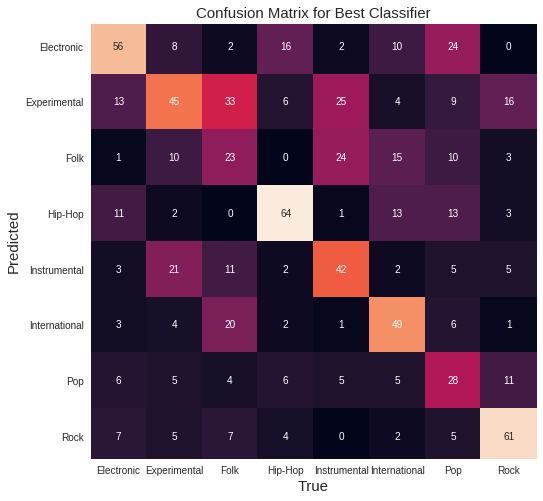

In [59]:
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=genre_dict.keys(),
            yticklabels=genre_dict.keys(), ax=ax)
plt.xlabel('True', size=15)
plt.ylabel('Predicted', size=15)
plt.title('Confusion Matrix for Best Classifier', size=15)
ax.set_ylim(8-0.1, 0.1)
#plt.savefig('../images/simple_conf_mat.png')